# Bank Customer Churn Analysis (Leakage-Aware)

This notebook cleans a bank churn dataset, explores key churn drivers, engineers features, and trains an interpretable baseline model. During modeling we detect and correct **data leakage** to ensure realistic performance.


## 1. Load data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data/Customer-Churn-Records.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


## 2. Initial inspection

Quick shape/info checks to confirm the dataset loaded correctly.

In [5]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   creditscore         10000 non-null  int64  
 1   geography           10000 non-null  object 
 2   gender              10000 non-null  object 
 3   age                 10000 non-null  int64  
 4   tenure              10000 non-null  int64  
 5   balance             10000 non-null  float64
 6   numofproducts       10000 non-null  int64  
 7   hascrcard           10000 non-null  int32  
 8   isactivemember      10000 non-null  int32  
 9   estimatedsalary     10000 non-null  float64
 10  exited              10000 non-null  int32  
 11  complain            10000 non-null  int32  
 12  satisfaction_score  10000 non-null  int64  
 13  card_type           10000 non-null  object 
 14  point_earned        10000 non-null  int64  
dtypes: float64(2), int32(4), int64(6), object(3)
memory us

In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


## 3. Cleaning

Standardize column names, drop non-informative identifiers, check missing values, and fix data types.

In [6]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited', 'complain',
       'satisfaction_score', 'card_type', 'point_earned'],
      dtype='object')

In [7]:
id_cols = ['rownumber', 'customerid', 'surname']
df.drop(columns=id_cols, inplace=True)

In [9]:
df.isna().sum()

creditscore           0
geography             0
gender                0
age                   0
tenure                0
balance               0
numofproducts         0
hascrcard             0
isactivemember        0
estimatedsalary       0
exited                0
complain              0
satisfaction_score    0
card_type             0
point_earned          0
dtype: int64

In [10]:
binary_cols = [
    'hascrcard',
    'isactivemember',
    'complain',
    'exited'
]

df[binary_cols] = df[binary_cols].astype(int)

In [28]:
df.rename(columns={
    'creditscore' : 'credit_score',
    'hascrcard': 'has_cr_card',
    'isactivemember': 'is_active_member',
    'numofproducts': 'num_of_products',
    'estimatedsalary' : 'estimated_salary'
}, inplace=True)

## 4. Sanity checks

Validate ranges/distributions for key fields (age, balance, satisfaction, etc.).

In [11]:
df['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

In [12]:
df['balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64

In [13]:
df['satisfaction_score'].value_counts().sort_index()

satisfaction_score
1    1932
2    2014
3    2042
4    2008
5    2004
Name: count, dtype: int64

In [14]:
df['card_type'].value_counts()

card_type
DIAMOND     2507
GOLD        2502
SILVER      2496
PLATINUM    2495
Name: count, dtype: int64

In [15]:
df['exited'].value_counts()

exited
0    7962
1    2038
Name: count, dtype: int64

## 5. EDA: Churn drivers

Explore churn rate by activity, complaints, satisfaction, and products.

In [17]:
#standardized column names, removed non-informative identifiers, validated data integrity, and prepared the dataset for exploratory analysis and modeling

In [18]:
df['exited'].unique()

array([1, 0])

In [19]:
df['exited'].value_counts()

exited
0    7962
1    2038
Name: count, dtype: int64

In [20]:
#churn is around 20 percent

In [21]:
df['exited'].value_counts(normalize=True)

exited
0    0.7962
1    0.2038
Name: proportion, dtype: float64

In [22]:
churn_rate = df['exited'].mean()
churn_rate

np.float64(0.2038)

In [23]:
#visualizing churn distribution

In [24]:
import matplotlib.pyplot as plt

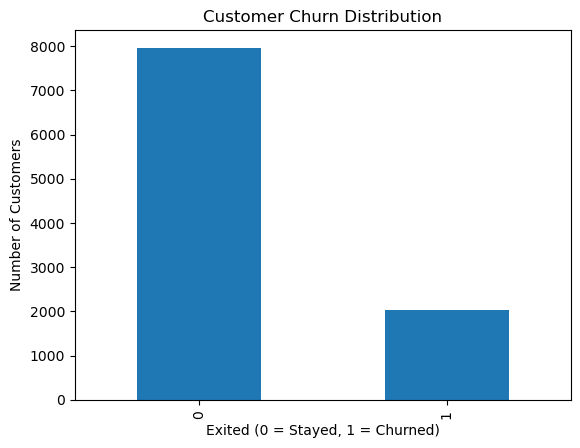

In [25]:
df['exited'].value_counts().plot(kind='bar')
plt.title("Customer Churn Distribution")
plt.xlabel("Exited (0 = Stayed, 1 = Churned)")
plt.ylabel("Number of Customers")
plt.show() 

In [26]:
df.columns.tolist()

['creditscore',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'numofproducts',
 'hascrcard',
 'isactivemember',
 'estimatedsalary',
 'exited',
 'complain',
 'satisfaction_score',
 'card_type',
 'point_earned']

In [27]:
df.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited', 'complain', 'satisfaction_score', 'card_type',
       'point_earned'],
      dtype='object')

In [28]:
df.rename(columns={
    'creditscore' : 'credit_score',
    'hascrcard': 'has_cr_card',
    'isactivemember': 'is_active_member',
    'numofproducts': 'num_of_products',
    'estimatedsalary' : 'estimated_salary'
}, inplace=True)

In [29]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited', 'complain', 'satisfaction_score',
       'card_type', 'point_earned'],
      dtype='object')

In [30]:
pd.crosstab(
    df['is_active_member'],
    df['exited'],
    normalize='index'
)

#cross tabulation for comparison

exited,0,1
is_active_member,,
0,0.731285,0.268715
1,0.857309,0.142691


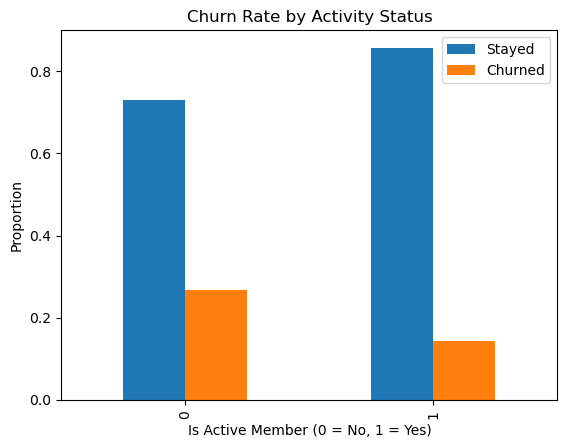

In [31]:
activity_churn = (
    pd.crosstab(df['is_active_member'], df['exited'], normalize='index')
)

activity_churn.plot(kind='bar')
plt.title("Churn Rate by Activity Status")
plt.xlabel("Is Active Member (0 = No, 1 = Yes)")
plt.ylabel("Proportion")
plt.legend(["Stayed", "Churned"])
plt.show()

In [32]:
pd.crosstab(
    df['complain'],
    df['exited'],
    normalize='index'
)

exited,0,1
complain,,
0,0.999497,0.000503
1,0.004892,0.995108


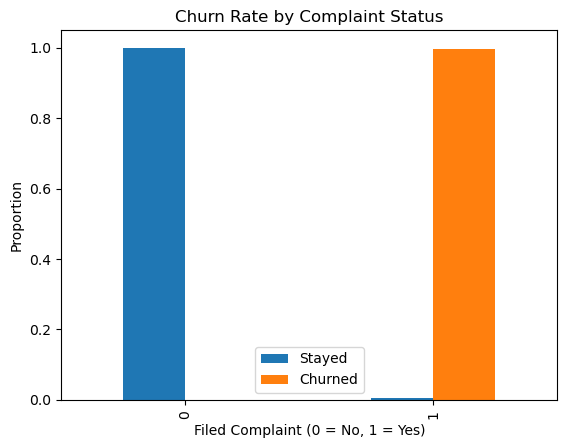

In [33]:
complaint_churn = pd.crosstab(
    df['complain'],
    df['exited'],
    normalize='index'
)

complaint_churn.plot(kind='bar')
plt.title("Churn Rate by Complaint Status")
plt.xlabel("Filed Complaint (0 = No, 1 = Yes)")
plt.ylabel("Proportion")
plt.legend(["Stayed", "Churned"])
plt.show()

In [34]:
pd.crosstab(
    df['satisfaction_score'],
    df['exited'],
    normalize='index'
).sort_index()

exited,0,1
satisfaction_score,,
1,0.799689,0.200311
2,0.782026,0.217974
3,0.803624,0.196376
4,0.793825,0.206175
5,0.801896,0.198104


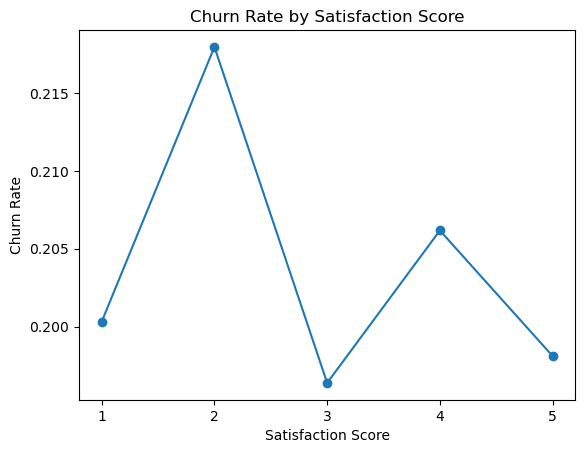

In [35]:
sat_churn = (
    pd.crosstab(df['satisfaction_score'], df['exited'], normalize='index')
    .sort_index()
)

sat_churn[1].plot(marker='o')
plt.title("Churn Rate by Satisfaction Score")
plt.xlabel("Satisfaction Score")
plt.ylabel("Churn Rate")
plt.xticks(sat_churn.index)
plt.show()

In [36]:
pd.crosstab(
    [df['complain'], df['satisfaction_score']],
    df['exited'],
    normalize='index'
)

exited                              0         1
complain satisfaction_score                    
0        1                   0.999353  0.000647
         2                   0.998731  0.001269
         3                   1.000000  0.000000
         4                   0.999373  0.000627
         5                   1.000000  0.000000
1        1                   0.002584  0.997416
         2                   0.002283  0.997717
         3                   0.012315  0.987685
         4                   0.000000  1.000000
         5                   0.007500  0.992500

In [37]:
df['satisfaction_score'].value_counts().sort_index()

satisfaction_score
1    1932
2    2014
3    2042
4    2008
5    2004
Name: count, dtype: int64

In [38]:
#churn is skyrocketing at 2 satisfaction, not so much 1...

pd.crosstab(
    [df['satisfaction_score'], df['is_active_member']],
    df['exited'],
    normalize='index'
)

exited                                      0         1
satisfaction_score is_active_member                    
1                  0                 0.745512  0.254488
                   1                 0.851777  0.148223
2                  0                 0.709970  0.290030
                   1                 0.852106  0.147894
3                  0                 0.731959  0.268041
                   1                 0.868470  0.131530
4                  0                 0.728916  0.271084
                   1                 0.857708  0.142292
5                  0                 0.741251  0.258749
                   1                 0.855796  0.144204

In [39]:
#satisfaction vs complaints

pd.crosstab(
    [df['satisfaction_score'], df['complain']],
    df['exited'],
    normalize='index'
)

exited                              0         1
satisfaction_score complain                    
1                  0         0.999353  0.000647
                   1         0.002584  0.997416
2                  0         0.998731  0.001269
                   1         0.002283  0.997717
3                  0         1.000000  0.000000
                   1         0.012315  0.987685
4                  0         0.999373  0.000627
                   1         0.000000  1.000000
5                  0         1.000000  0.000000
                   1         0.007500  0.992500

In [45]:
###Interaction Insight: Silent Churn Risk

In [46]:
#satisfaction vs activity status

pd.crosstab(
    [df['satisfaction_score'], df['is_active_member']],
    df['exited'],
    normalize='index'
)


exited                                      0         1
satisfaction_score is_active_member                    
1                  0                 0.745512  0.254488
                   1                 0.851777  0.148223
2                  0                 0.709970  0.290030
                   1                 0.852106  0.147894
3                  0                 0.731959  0.268041
                   1                 0.868470  0.131530
4                  0                 0.728916  0.271084
                   1                 0.857708  0.142292
5                  0                 0.741251  0.258749
                   1                 0.855796  0.144204

In [47]:
#satisfaction vs complaints

pd.crosstab(
    [df['satisfaction_score'], df['complain']],
    df['exited'],
    normalize='index'
)

exited                              0         1
satisfaction_score complain                    
1                  0         0.999353  0.000647
                   1         0.002584  0.997416
2                  0         0.998731  0.001269
                   1         0.002283  0.997717
3                  0         1.000000  0.000000
                   1         0.012315  0.987685
4                  0         0.999373  0.000627
                   1         0.000000  1.000000
5                  0         1.000000  0.000000
                   1         0.007500  0.992500

In [48]:
interaction = pd.crosstab(
    [df['satisfaction_score'], df['is_active_member']],
    df['exited'],
    normalize='index'
).reset_index()

interaction

exited,satisfaction_score,is_active_member,0,1
0,1,0,0.745512,0.254488
1,1,1,0.851777,0.148223
2,2,0,0.709970,0.290030
3,2,1,0.852106,0.147894
4,3,0,0.731959,0.268041
5,3,1,0.868470,0.131530
6,4,0,0.728916,0.271084
7,4,1,0.857708,0.142292
8,5,0,0.741251,0.258749
9,5,1,0.855796,0.144204


In [ ]:
#check balances to see if there is a correlation between complaints, satisfaction_score, and balance

## 6. Feature engineering

Engineer interpretable features based on EDA findings.

In [49]:
(df['balance'] == 0).value_counts()

balance
False    6383
True     3617
Name: count, dtype: int64

In [ ]:
#3,617 of the entries have zero balance

In [52]:
#['balance'] == 0 is boolean to tell us True/False of 0 balance. 

pd.crosstab(
    [df['balance'] == 0, df['satisfaction_score']],
    df['exited'],
    normalize='index'
)

exited                             0         1
balance satisfaction_score                    
False   1                   0.759615  0.240385
        2                   0.741036  0.258964
        3                   0.774981  0.225019
        4                   0.748621  0.251379
        5                   0.770000  0.230000
True    1                   0.872807  0.127193
        2                   0.849802  0.150198
        3                   0.854993  0.145007
        4                   0.871448  0.128552
        5                   0.860795  0.139205

In [57]:
#Balance does not appear to drive churn. Zero-balance customers churn less across satisfaction levels,
#suggesting balance alone is not a meaningful churn risk indicator in this dataset.

In [58]:
df['inactive_flag'] = (df['is_active_member'] == 0).astype(int)

In [59]:
df['complaint_flag'] = df['complain']

In [60]:
def satisfaction_bucket(score):
    if score <= 2:
        return 'low'
    elif score == 3:
        return 'neutral'
    else:
        return 'high'

df['satisfaction_bucket'] = df['satisfaction_score'].apply(satisfaction_bucket)

In [61]:
df['silent_risk_flag'] = (
    (df['satisfaction_score'] == 2) &
    (df['complain'] == 0)
).astype(int)

In [62]:
df['zero_balance_flag'] = (df['balance'] == 0).astype(int)

In [63]:
def tenure_bucket(years):
    if years <= 2:
        return 'new'
    elif years <= 5:
        return 'mid'
    else:
        return 'long'

df['tenure_bucket'] = df['tenure'].apply(tenure_bucket)

In [64]:
df['single_product_flag'] = (df['num_of_products'] == 1).astype(int)

In [65]:
df[
    [
        'inactive_flag',
        'complaint_flag',
        'silent_risk_flag',
        'zero_balance_flag',
        'single_product_flag'
    ]
].mean()

inactive_flag          0.4849
complaint_flag         0.2044
silent_risk_flag       0.1576
zero_balance_flag      0.3617
single_product_flag    0.5084
dtype: float64

In [66]:
tenure_bucket

<function __main__.tenure_bucket(years)>

In [67]:
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,...,satisfaction_score,card_type,point_earned,inactive_flag,complaint_flag,satisfaction_bucket,silent_risk_flag,zero_balance_flag,tenure_bucket,single_product_flag
0,619,France,Female,42,2,0.00,1,1,1,101348.88,...,2,DIAMOND,464,0,1,low,0,1,new,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,...,3,DIAMOND,456,0,1,neutral,0,0,new,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,...,3,DIAMOND,377,1,1,neutral,0,0,long,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,...,5,GOLD,350,1,0,high,0,1,new,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,...,5,GOLD,425,0,0,high,0,0,new,1


In [83]:
df.columns.tolist()

['credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited',
 'complain',
 'satisfaction_score',
 'card_type',
 'point_earned',
 'inactive_flag',
 'complaint_flag',
 'satisfaction_bucket',
 'silent_risk_flag',
 'zero_balance_flag',
 'tenure_bucket',
 'single_product_flag']

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

X = df[['is_active_member']]
y = df['exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train)

y_pred = model.predict(X_test_s)
print(classification_report(y_test, y_pred))

/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1991
           1       0.00      0.00      0.00       509

    accuracy                           0.80      2500
   macro avg       0.40      0.50      0.44      2500
weighted avg       0.63      0.80      0.71      2500



In [85]:
X = df[['complain']]
y = df['exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train)

y_pred = model.predict(X_test_s)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1991
           1       1.00      1.00      1.00       509

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



In [86]:
df = df.drop(columns=[
    'complain',
    'complaint_flag',
    'silent_risk_flag'
])

## 7. Modeling (baseline logistic regression)

Train a baseline model, then **validate** results. If performance is unrealistically perfect, investigate leakage and remove post-outcome features.

In [87]:
df.columns.tolist()

['credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited',
 'satisfaction_score',
 'card_type',
 'point_earned',
 'inactive_flag',
 'satisfaction_bucket',
 'zero_balance_flag',
 'tenure_bucket',
 'single_product_flag']

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

features = [
    'age',
    'credit_score',
    'tenure',
    'num_of_products',
    'is_active_member'
]

X = df[features]
y = df['exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train)

y_pred = model.predict(X_test_s)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1991
           1       0.62      0.10      0.17       509

    accuracy                           0.80      2500
   macro avg       0.72      0.54      0.53      2500
weighted avg       0.77      0.80      0.74      2500



In [90]:
y_prob = model.predict_proba(X_test_s)[:, 1]

In [91]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_30 = (y_prob >= 0.30).astype(int)

print(classification_report(y_test, y_pred_30))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1991
           1       0.50      0.48      0.49       509

    accuracy                           0.80      2500
   macro avg       0.68      0.68      0.68      2500
weighted avg       0.79      0.80      0.79      2500



In [92]:
import pandas as pd

coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

coef_df

,feature,coefficient
0,age,0.718909
2,tenure,0.004406
1,credit_score,-0.081190
3,num_of_products,-0.094397
4,is_active_member,-0.517200


## 8. Model findings

Model Findings (Leakage-Aware Logistic Regression)
###After removing post-outcome and leaky variables, a baseline logistic regression model was trained using demographic and engagement-related features. The model achieved realistic performance and provided interpretable insights into churn risk.

###Key findings:
#- **Age** emerged as the strongest positive predictor of churn, indicating higher churn risk among older customers.
#- **Customer activity** was a strong protective factor; active members were significantly less likely to churn.
#- **Product engagement** (number of products) showed a modest negative relationship with churn, supporting the idea that multi-product customers are more “sticky.”
#- **Credit score** contributed a weak but reasonable protective effect.
#- **Tenure** showed minimal additional predictive value once other features were included.

#Overall, the model confirms that **customer engagement and lifecycle characteristics** are more informative for churn prediction than raw financial metrics. Threshold tuning was used to improve churn recall, demonstrating how model outputs can be adjusted to better support proactive retention strategies.
